# **Setting Up Environment**

In [4]:
from google.colab import drive
drive.mount("/content/drive")
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Installing Modules**

In [5]:
%%capture
!pip install imblearn
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install scorecardpy
!pip install dtype_diet
!pip install pandas==1.3.5 # For dependency issue related to quantile function

## **Loading Libraries**

In [6]:
import pandas as pd
from pandas.core.algorithms import quantile
import numpy as np
import re
import pandas.core.algorithms as algos
import traceback
import string

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
import statsmodels
import scipy.stats as stats

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Optimize dataframe
from dtype_diet import report_on_dataframe, optimize_dtypes

# Imbalance class treatment
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

# Modelling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Scorecard
import scorecardpy as sc
import mlxtend

# Setting up display for pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# **Data Preprocessing**

### **Data Loading**

In [77]:
train = pd.read_csv('drive/MyDrive/data/train_credit.csv')
train.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


In [78]:
df = train.sample(n = 40000, random_state = 42, replace = False)
df

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
34126,CST_163708,Wachtel,50,F,N,Y,0.0,269502.14,4181.0,Unknown,1.0,0.0,17440.44,36017.45,23,807.0,0,0,0
44609,CST_131305,Deepa,29,F,N,Y,0.0,115795.25,365250.0,Unknown,2.0,0.0,28962.21,21781.38,60,858.0,0,0,0
44264,CST_131350,Jason,39,F,N,Y,0.0,113477.67,365241.0,Unknown,2.0,0.0,27463.96,27485.15,81,667.0,0,0,1
33556,CST_106655,Gilbert Kreijger,35,F,Y,Y,1.0,215555.19,1882.0,Managers,3.0,0.0,47863.75,25054.25,32,690.0,0,0,0
28050,CST_154013,Slater,53,M,Y,Y,0.0,185082.22,365244.0,Unknown,2.0,0.0,47185.73,65186.23,65,721.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18350,CST_107386,ra Alper,46,M,Y,N,0.0,364214.11,365242.0,Unknown,2.0,0.0,40844.95,78283.62,17,818.0,0,0,0
30771,CST_134432,"""Eileen",31,M,Y,Y,0.0,193043.05,3400.0,Drivers,2.0,1.0,41271.79,24474.30,49,841.0,0,0,0
1466,CST_157710,Kaneko,29,M,Y,Y,1.0,147234.72,270.0,Laborers,2.0,1.0,46915.73,36277.44,97,509.0,1,0,1
12615,CST_158265,Mutikani,30,F,N,Y,0.0,57269.30,365244.0,Unknown,2.0,0.0,8075.89,17438.19,6,924.0,0,0,0


## **Splitting Numerical and Categorical (For Further Use)**

In [79]:
def split_features(df):
  df_aux = df.copy()
  numerical = [i for i in df_aux.columns if (df_aux[i].dtypes != 'category') & (df_aux[i].dtypes != 'object') & (i != 'credit_card_default')]
  numerical_df = df_aux[numerical]
  categorical = [i for i in df_aux.columns if i not in numerical]
  print(numerical)
  categorical_df = df_aux[categorical]
  categorical_df.drop(columns = ['credit_card_default'], inplace = True)
  discrete_numerical = numerical_df[['no_of_children','total_family_members','migrant_worker','prev_defaults','default_in_last_6months']]
  numerical_df.drop(['no_of_children','total_family_members','migrant_worker','prev_defaults','default_in_last_6months'],axis=1,inplace=True)
  categorical_df = pd.concat([categorical_df, discrete_numerical],axis=1)
  return numerical_df,categorical_df

In [80]:
numerical_df, categorical_df = split_features(df)

['age', 'no_of_children', 'net_yearly_income', 'no_of_days_employed', 'total_family_members', 'migrant_worker', 'yearly_debt_payments', 'credit_limit', 'credit_limit_used(%)', 'credit_score', 'prev_defaults', 'default_in_last_6months']


/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [81]:
categorical_df

,customer_id,name,gender,owns_car,owns_house,occupation_type,no_of_children,total_family_members,migrant_worker,prev_defaults,default_in_last_6months
34126,CST_163708,Wachtel,F,N,Y,Unknown,0.0,1.0,0.0,0,0
44609,CST_131305,Deepa,F,N,Y,Unknown,0.0,2.0,0.0,0,0
44264,CST_131350,Jason,F,N,Y,Unknown,0.0,2.0,0.0,0,0
33556,CST_106655,Gilbert Kreijger,F,Y,Y,Managers,1.0,3.0,0.0,0,0
28050,CST_154013,Slater,M,Y,Y,Unknown,0.0,2.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
18350,CST_107386,ra Alper,M,Y,N,Unknown,0.0,2.0,0.0,0,0
30771,CST_134432,"""Eileen",M,Y,Y,Drivers,0.0,2.0,1.0,0,0
1466,CST_157710,Kaneko,M,Y,Y,Laborers,1.0,2.0,1.0,1,0
12615,CST_158265,Mutikani,F,N,Y,Unknown,0.0,2.0,0.0,0,0


## **EDA (Exploratory Data Analysis)**

### **Checking Shape**

In [82]:
# check shape and length
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns")

The dataset has 40000 rows and 19 columns


### **Checking Duplicates**

In [83]:
# Checking duplicates
count_duplicate_rows = len(df)-len(df.drop_duplicates())
print(f"There are {count_duplicate_rows} duplicate rows")

There are 0 duplicate rows


### **Checking Imbalance**

In [84]:
# Checking for imbalance in the original and subset
print(f'Class distribution original data:\n{train["credit_card_default"].value_counts(normalize=True) * 100}')
print('-'*40)
print(f'Class distribution subset data:\n{df["credit_card_default"].value_counts(normalize=True) * 100}')

Class distribution original data:
0    91.879722
1     8.120278
Name: credit_card_default, dtype: float64
----------------------------------------
Class distribution subset data:
0    91.8375
1     8.1625
Name: credit_card_default, dtype: float64


### **Checking NaN Valus**

In [85]:
# Checking NaN values
def check_null(df):
  for column in df.columns:
      missing = df[column].isna().sum() / df.shape[0]
      print(f"{column:{20}}: ==============> {missing * 100:.2f}%")

print('-'*80)
print('Check NaN values for dataframe')
print(check_null(df))

--------------------------------------------------------------------------------
Check NaN values for dataframe
customer_id         : ==============> 0.00%
name                : ==============> 0.00%
age                 : ==============> 0.00%
gender              : ==============> 0.00%
owns_car            : ==============> 1.24%
owns_house          : ==============> 0.00%
no_of_children      : ==============> 1.71%
net_yearly_income   : ==============> 0.00%
no_of_days_employed : ==============> 1.02%
occupation_type     : ==============> 0.00%
total_family_members: ==============> 0.18%
migrant_worker      : ==============> 0.19%
yearly_debt_payments: ==============> 0.22%
credit_limit        : ==============> 0.00%
credit_limit_used(%): ==============> 0.00%
credit_score        : ==============> 0.02%
prev_defaults       : ==============> 0.00%
default_in_last_6months: ==============> 0.00%
credit_card_default : ==============> 0.00%
None


### **Checking Information (After Optimizing)**

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 34126 to 13543
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              40000 non-null  object 
 1   name                     40000 non-null  object 
 2   age                      40000 non-null  int64  
 3   gender                   40000 non-null  object 
 4   owns_car                 39504 non-null  object 
 5   owns_house               40000 non-null  object 
 6   no_of_children           39315 non-null  float64
 7   net_yearly_income        40000 non-null  float64
 8   no_of_days_employed      39591 non-null  float64
 9   occupation_type          40000 non-null  object 
 10  total_family_members     39929 non-null  float64
 11  migrant_worker           39924 non-null  float64
 12  yearly_debt_payments     39913 non-null  float64
 13  credit_limit             40000 non-null  float64
 14  credit_limit_used(

### **Categorial features - Numerical features**

In [87]:
cat_feats = [col for col in df.columns if (df[col].dtypes == "category") or
 (df[col].dtypes == 'object')]
num_feats =  [col for col in df.columns if col not in cat_feats]

print("Number of categorical feats: ", len(cat_feats))
print("Number of numerical feats: ", len(num_feats))

print("Discrete numerical features: \n")
for feat in num_feats:
  if len(df[feat].value_counts()) <= 20:
    print("Variable Name:", feat)
    print(df[feat].value_counts())
    print("-"*50)

Number of categorical feats:  6
Number of numerical feats:  13
Discrete numerical features: 

Variable Name: no_of_children
0.0    27425
1.0     7910
2.0     3393
3.0      513
4.0       54
5.0       12
6.0        6
7.0        1
9.0        1
Name: no_of_children, dtype: int64
--------------------------------------------------
Variable Name: total_family_members
2.0     20614
1.0      8700
3.0      6865
4.0      3184
5.0       496
6.0        51
7.0        11
8.0         6
9.0         1
10.0        1
Name: total_family_members, dtype: int64
--------------------------------------------------
Variable Name: migrant_worker
0.0    32812
1.0     7112
Name: migrant_worker, dtype: int64
--------------------------------------------------
Variable Name: prev_defaults
0    37831
1     1908
2      261
Name: prev_defaults, dtype: int64
--------------------------------------------------
Variable Name: default_in_last_6months
0    37970
1     2030
Name: default_in_last_6months, dtype: int64
-----------

### **Ranking Number of NaN Values**

In [88]:
df.isnull().sum().sort_values(ascending=False).head(10)

no_of_children             685
owns_car                   496
no_of_days_employed        409
yearly_debt_payments        87
migrant_worker              76
total_family_members        71
credit_score                 7
customer_id                  0
default_in_last_6months      0
prev_defaults                0
dtype: int64

### **Checking Indicator Variables**

In [89]:
print(df["credit_card_default"].value_counts())
print(df["credit_card_default"].value_counts(normalize=True))

0    36735
1     3265
Name: credit_card_default, dtype: int64
0    0.918375
1    0.081625
Name: credit_card_default, dtype: float64


## **Imputing NaN Values: Categorical features**

In [90]:
df[cat_feats].isnull().sum()

customer_id          0
name                 0
gender               0
owns_car           496
owns_house           0
occupation_type      0
dtype: int64

As there are missing values mostly less than 2%, so, let us impute all missing values with statistical way.
That is, FillNA by MODE if it is *categorical* variable or *discrete* numerical variable  and FillNA by MEDIAN if it is *continuous* numerical variable.

### **Gender**

In [91]:
df[df['gender'] == 'XNA']

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
28498,CST_144669,ernard,52,XNA,N,Y,2.0,203596.95,2806.0,Low-skill Laborers,4.0,0.0,14700.2,65487.34,40,669.0,0,0,0


In [92]:
# change it to M since the name pronunces as Male
df['gender'] = df['gender'].apply(lambda x: 'M' if x=='XNA' else x)
df['gender'].value_counts()

F    26297
M    13703
Name: gender, dtype: int64

### **Owns car**

In [93]:
# fill owns_car with mode of the data
df['owns_car'].fillna(df['owns_car'].mode()[0], inplace=True)

In [94]:
df["owns_car"].value_counts(normalize=True)

N    0.665375
Y    0.334625
Name: owns_car, dtype: float64

In [95]:
df[cat_feats].isnull().sum()

customer_id        0
name               0
gender             0
owns_car           0
owns_house         0
occupation_type    0
dtype: int64

## **Imputing NaN Values: Numerical Features**

In [96]:
df[num_feats].isnull().sum().sort_values(ascending=False).head(10)

no_of_children          685
no_of_days_employed     409
yearly_debt_payments     87
migrant_worker           76
total_family_members     71
credit_score              7
age                       0
net_yearly_income         0
credit_limit              0
credit_limit_used(%)      0
dtype: int64

### **no_of_days_employed**

In [97]:
# impute 'no_of_days_employed' with median based on 'occupation_type'
occp_days_employed = df.groupby(by='occupation_type')['no_of_days_employed'].median()

for i in occp_days_employed.index:
    df['no_of_days_employed'] = np.where((df['no_of_days_employed'].isna()) & (df['occupation_type'] == i), occp_days_employed[i], df['no_of_days_employed'])

In [98]:
df['no_of_days_employed'].isnull().sum()

0

### **yearly_debt_payments**

In [99]:
# impute 'yearly_debt_payments' with median based on 'credit_card_default'
yearDebt_credit = df.groupby(by='credit_card_default')['yearly_debt_payments'].median()
for i in yearDebt_credit.index:
    df['yearly_debt_payments'] = np.where((df['yearly_debt_payments'].isna()) & (df['credit_card_default'] == i), yearDebt_credit[i], df['yearly_debt_payments'])

In [100]:
df['yearly_debt_payments'].isnull().sum()

0

### **migrant_worker**

In [101]:
# imputing with mode of the data
df['migrant_worker'].fillna(df['migrant_worker'].mode()[0], inplace=True)

# check null values count
df['migrant_worker'].isna().sum()

0

### **total_family_members**

In [102]:
# imputing with mode of the data
df['total_family_members'].fillna(df['total_family_members'].mode()[0], inplace=True)

# check null values count
df['total_family_members'].isna().sum()

0

### **no_of_children**

In [103]:
# fill no_of_children with mode of the data
df['no_of_children'].fillna(df['no_of_children'].mode()[0], inplace=True)

### **credit_score**

In [104]:
# check medians of credit_score wrt credit_card_default
cred_score = df.groupby(by='credit_card_default')['credit_score'].median()

for i in cred_score.index:
    df['credit_score'] = np.where((df['credit_score'].isna()) & (df['credit_card_default'] == i), cred_score[i], df['credit_score'])

# check for null values in 'credit_score'
df['credit_score'].isna().sum()

0

In [105]:
df[num_feats].isnull().sum().sort_values(ascending = False)

age                        0
no_of_children             0
net_yearly_income          0
no_of_days_employed        0
total_family_members       0
migrant_worker             0
yearly_debt_payments       0
credit_limit               0
credit_limit_used(%)       0
credit_score               0
prev_defaults              0
default_in_last_6months    0
credit_card_default        0
dtype: int64

In [106]:
print('-'*80)
print('Check NaN values again for dataframe')
print(check_null(df))

--------------------------------------------------------------------------------
Check NaN values again for dataframe
customer_id         : ==============> 0.00%
name                : ==============> 0.00%
age                 : ==============> 0.00%
gender              : ==============> 0.00%
owns_car            : ==============> 0.00%
owns_house          : ==============> 0.00%
no_of_children      : ==============> 0.00%
net_yearly_income   : ==============> 0.00%
no_of_days_employed : ==============> 0.00%
occupation_type     : ==============> 0.00%
total_family_members: ==============> 0.00%
migrant_worker      : ==============> 0.00%
yearly_debt_payments: ==============> 0.00%
credit_limit        : ==============> 0.00%
credit_limit_used(%): ==============> 0.00%
credit_score        : ==============> 0.00%
prev_defaults       : ==============> 0.00%
default_in_last_6months: ==============> 0.00%
credit_card_default : ==============> 0.00%
None


## **Visualization**

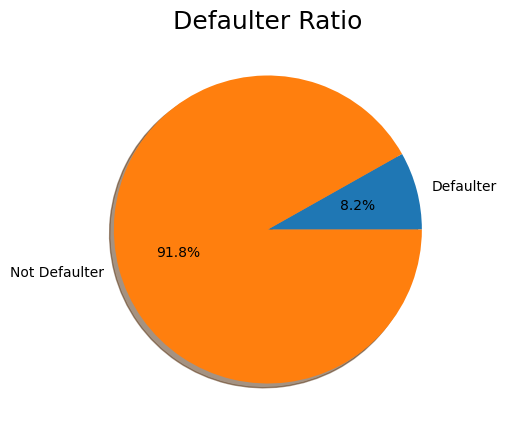

In [107]:
# Ploting Credit_default ratio
total_default_values = df['credit_card_default'].value_counts(ascending=True).values

plt.figure(figsize = (10,5))
plt.pie(total_default_values, labels=['Defaulter', 'Not Defaulter'], autopct='%1.1f%%', shadow=True)
plt.title('Defaulter Ratio', fontsize=18)
plt.show()

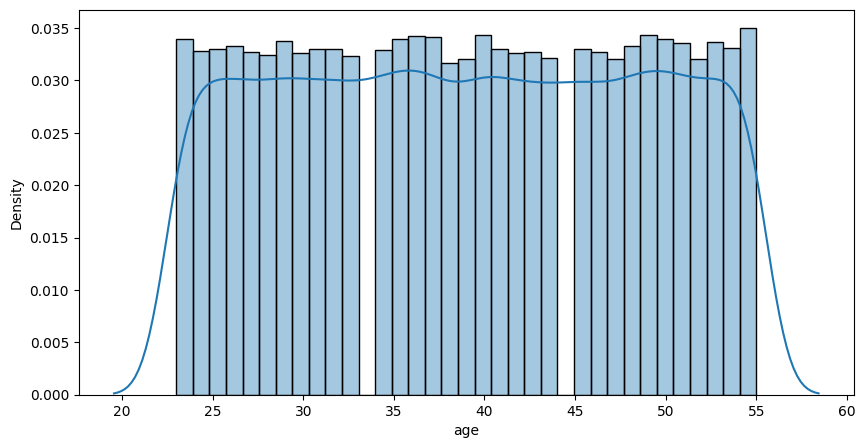

<Figure size 640x480 with 0 Axes>

In [108]:
# visualize AGE feature - distplot
plt.figure(figsize = (10,5))
sns.histplot(df['age'], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4)
plt.show()
plt.tight_layout()

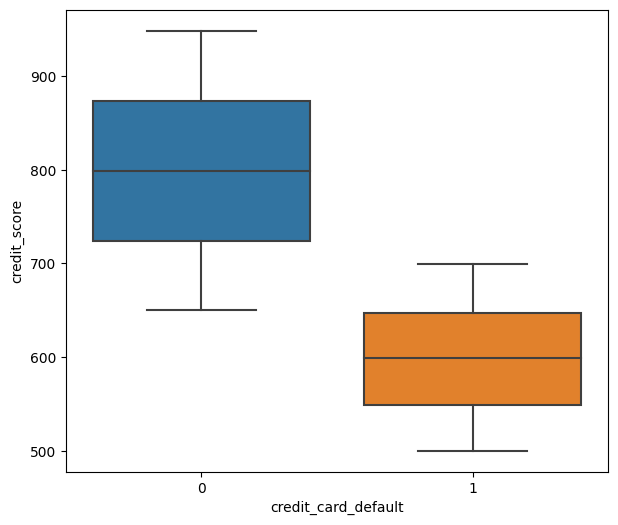

In [109]:
# boxplot of credit_defaulter-credit_score
plt.figure(figsize=[7,6])
sns.boxplot(x = df['credit_card_default'], y = df['credit_score'])
plt.show()

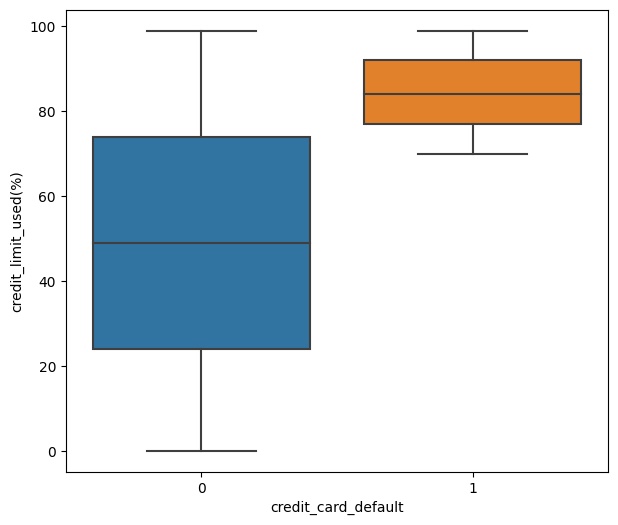

In [110]:
# boxplot of credit_defaulter-credit_limit_utilization
plt.figure(figsize=[7,6])
sns.boxplot(x = df['credit_card_default'], y = df['credit_limit_used(%)'])
plt.show()

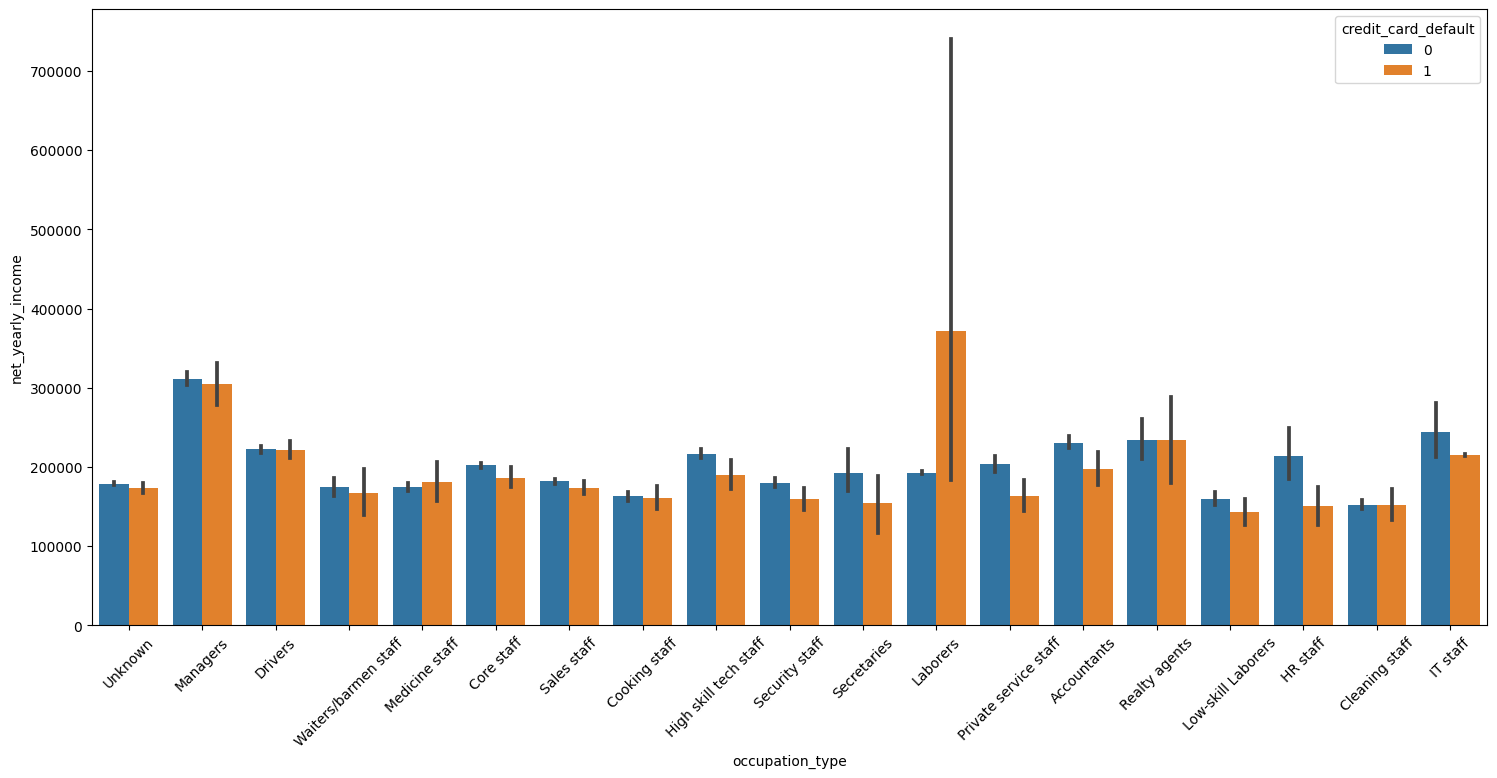

In [111]:
# barplots for occupation types wrt credit_default
plt.figure(figsize=[18,8])
sns.barplot(x = df['occupation_type'], y = df['net_yearly_income'], hue = df['credit_card_default'])
plt.xticks(rotation=45)
plt.show()

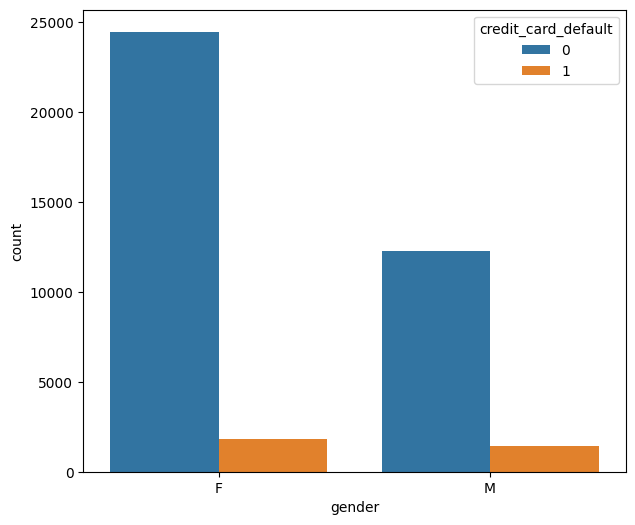

In [112]:
# male or female defaulters
plt.figure(figsize=[7,6])
sns.countplot(x = df['gender'], hue=df['credit_card_default'])
plt.show()

In [113]:
# histogram of all continuous variables

# plt.figure(figsize=(15,15))
# for idx, col in enumerate(numerical_df.columns):
#   plt.subplot(4,3,idx+1)
#   plt.hist(numerical_df[col],bins=50)
#   plt.xlabel(col)

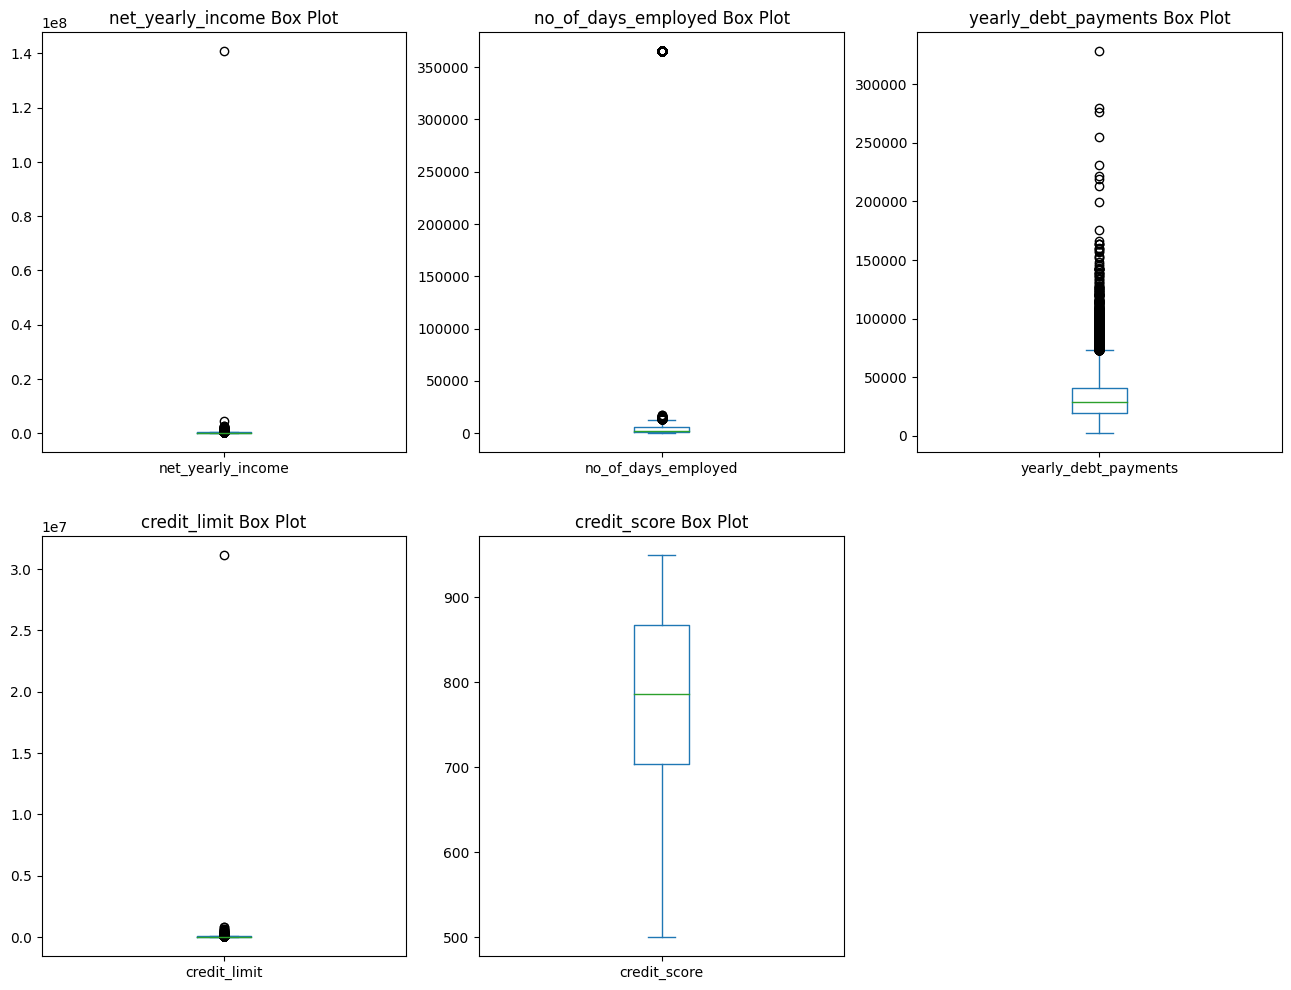

In [114]:
# boxplot of all continuous variables

plt.figure(figsize=[16, 12])
plt.subplot(2,3,1)
df['net_yearly_income'].plot.box()
plt.title('net_yearly_income Box Plot')

plt.subplot(2,3,2)
df['no_of_days_employed'].plot.box()
plt.title('no_of_days_employed Box Plot')

plt.subplot(2,3,3)
df['yearly_debt_payments'].plot.box()
plt.title('yearly_debt_payments Box Plot')

plt.subplot(2,3,4)
df['credit_limit'].plot.box()
plt.title('credit_limit Box Plot')

plt.subplot(2,3,5)
df['credit_score'].plot.box()
plt.title('credit_score Box Plot')
plt.show()

# **Data Processing**

## **Outlier**

In [187]:
# def outliers(data, threshold):
#   mean = np.mean(data)
#   std = np.std(data)
#   for i in data:
#     z = (i-mean)/std
#     if np.abs(z) > threshold:
#       data.loc[data == i] = mean

# for col in numerical_df.columns.tolist()[1:]:
#   outliers(df[col], 3)

## **Information Criteria Feature Selection**

In [115]:
max_bin = 20
force_bin = 3
# define a binning function
def mono_bin(Y, X, n = max_bin):

    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)})
        d2 = d1.groupby('Bucket', as_index=True)

    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()

    return(d3)

def char_bin(Y, X):

    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    df2 = notmiss.groupby('X',as_index=True)

    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)

    return(d3)

def data_vars(df1, target):

    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]

    x = df1.dtypes.index
    count = -1

    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1

            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)

    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [116]:
final_iv, IV = data_vars(df.drop(columns =["customer_id", "name", 'credit_card_default']), df["credit_card_default"])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [117]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,age,23,34,14480,1173,0.081008,13307,0.918992,0.359265,0.362243,-0.008255,0.000097
1,age,35,45,13311,1082,0.081286,12229,0.918714,0.331394,0.332898,-0.004529,0.000097
2,age,46,55,12209,1010,0.082726,11199,0.917274,0.309342,0.304859,0.014596,0.000097
3,gender,F,F,26297,1823,0.069323,24474,0.930677,0.558346,0.666231,-0.176658,0.049275
4,gender,M,M,13703,1442,0.105232,12261,0.894768,0.441654,0.333769,0.280078,0.049275
5,owns_car,N,N,26615,2250,0.084539,24365,0.915461,0.689127,0.663264,0.038253,0.003056
6,owns_car,Y,Y,13385,1015,0.075831,12370,0.924169,0.310873,0.336736,-0.079915,0.003056
7,owns_house,N,N,12159,998,0.082079,11161,0.917921,0.305666,0.303825,0.006043,0.000016
8,owns_house,Y,Y,27841,2267,0.081427,25574,0.918573,0.694334,0.696175,-0.002649,0.000016
9,no_of_children,0.0,1.0,36020,2916,0.080955,33104,0.919045,0.893109,0.901157,-0.008971,0.000702


In [118]:
IV.sort_values('IV')

,VAR_NAME,IV
12,owns_house,0.000016
0,age,0.000097
15,yearly_debt_payments,0.000152
1,credit_limit,0.000530
8,no_of_children,0.000702
11,owns_car,0.003056
7,net_yearly_income,0.003104
14,total_family_members,0.003348
13,prev_defaults,0.006660
6,migrant_worker,0.013717


In [119]:
IV.sort_values('IV', ascending=True).head(10)

,VAR_NAME,IV
12,owns_house,0.000016
0,age,0.000097
15,yearly_debt_payments,0.000152
1,credit_limit,0.000530
8,no_of_children,0.000702
11,owns_car,0.003056
7,net_yearly_income,0.003104
14,total_family_members,0.003348
13,prev_defaults,0.006660
6,migrant_worker,0.013717


In [120]:
IV.sort_values('IV', ascending=True).head(10)["VAR_NAME"].values

array(['owns_house', 'age', 'yearly_debt_payments', 'credit_limit',
       'no_of_children', 'owns_car', 'net_yearly_income',
       'total_family_members', 'prev_defaults', 'migrant_worker'],
      dtype=object)

**We will drop some low (< 0.02) IV columns**

In [121]:
low_IV_cols =  ['age', 'owns_house', 'yearly_debt_payments', 'credit_limit',
      'no_of_children', 'total_family_members', 'net_yearly_income',
       'owns_car', 'prev_defaults', 'migrant_worker']

## **WOE binning**

[INFO] creating woe binning ...
Binning on 40000 rows and 17 columns in 00:00:15


{'credit_limit_used(%)': <Figure size 640x480 with 2 Axes>,
 'net_yearly_income': <Figure size 640x480 with 2 Axes>,
 'owns_car': <Figure size 640x480 with 2 Axes>,
 'credit_score': <Figure size 640x480 with 2 Axes>,
 'age': <Figure size 640x480 with 2 Axes>,
 'no_of_children': <Figure size 640x480 with 2 Axes>,
 'prev_defaults': <Figure size 640x480 with 2 Axes>,
 'no_of_days_employed': <Figure size 640x480 with 2 Axes>,
 'yearly_debt_payments': <Figure size 640x480 with 2 Axes>,
 'owns_house': <Figure size 640x480 with 2 Axes>,
 'migrant_worker': <Figure size 640x480 with 2 Axes>,
 'default_in_last_6months': <Figure size 640x480 with 2 Axes>,
 'gender': <Figure size 640x480 with 2 Axes>,
 'credit_limit': <Figure size 640x480 with 2 Axes>,
 'total_family_members': <Figure size 640x480 with 2 Axes>,
 'occupation_type': <Figure size 640x480 with 2 Axes>}

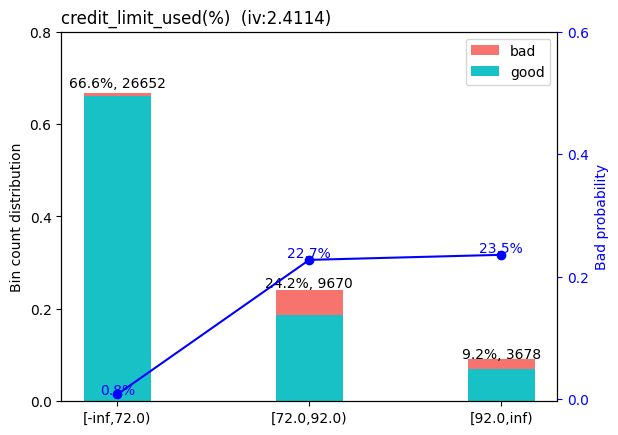

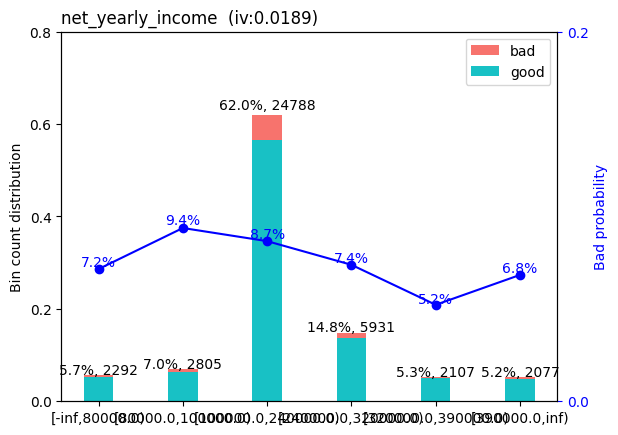

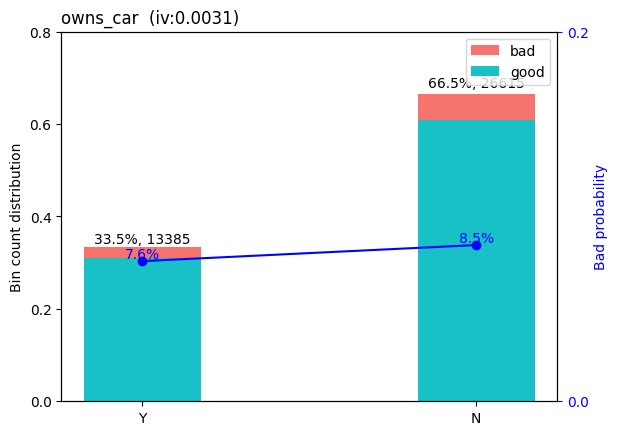

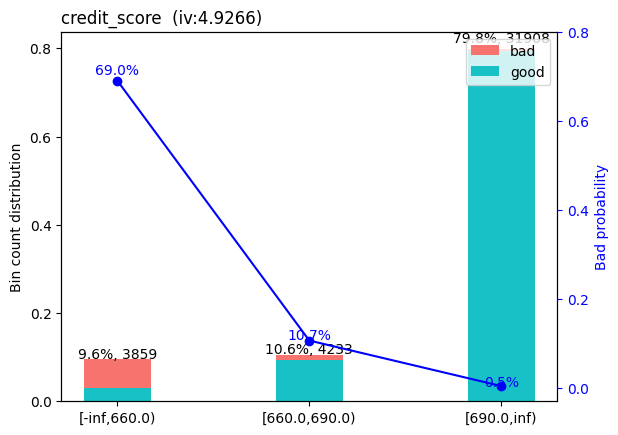

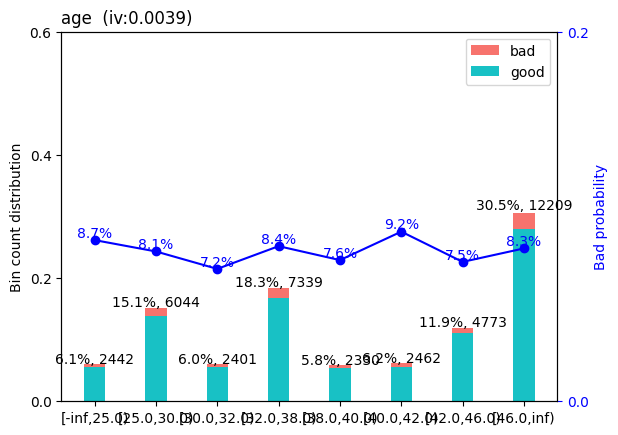

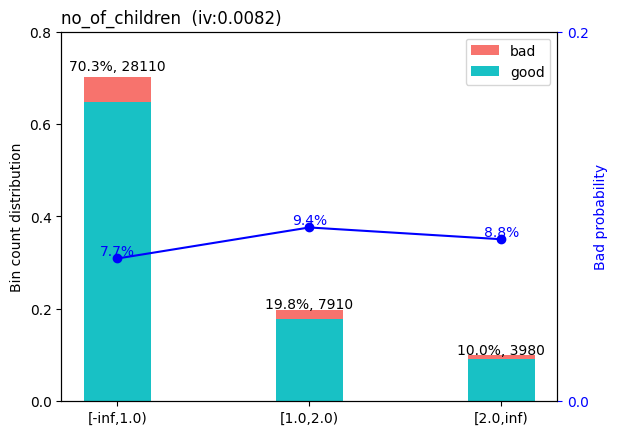

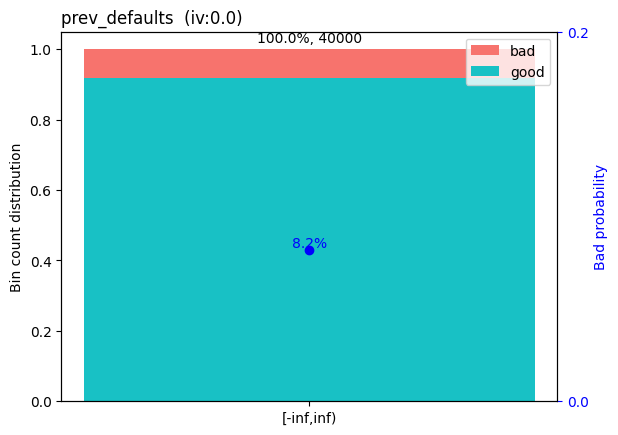

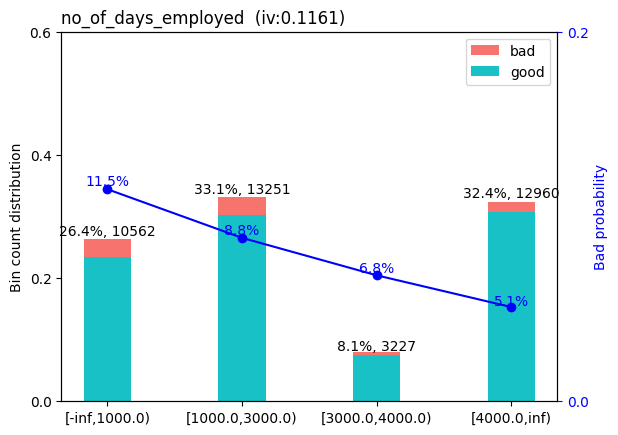

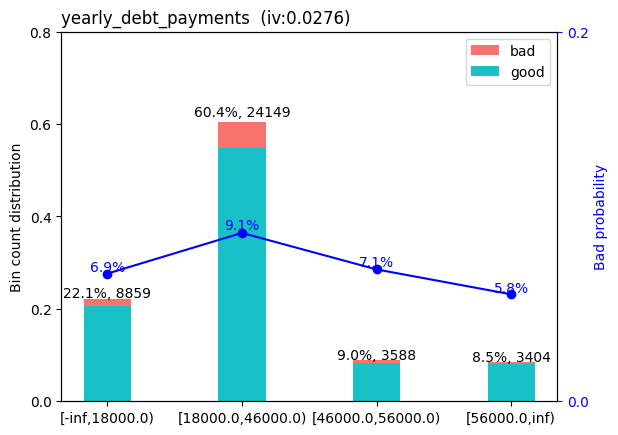

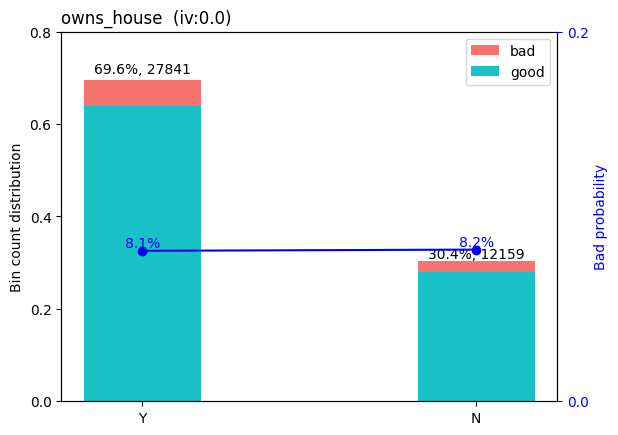

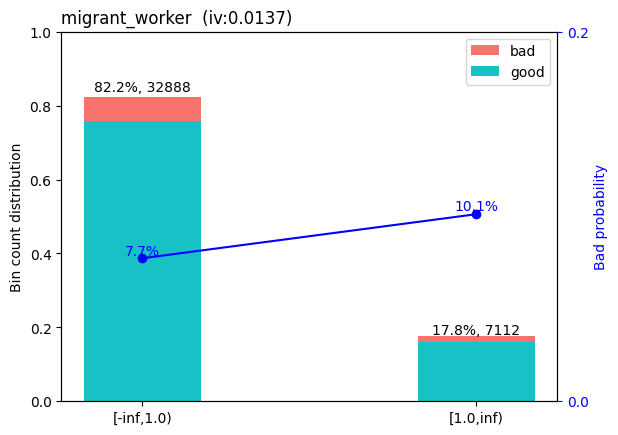

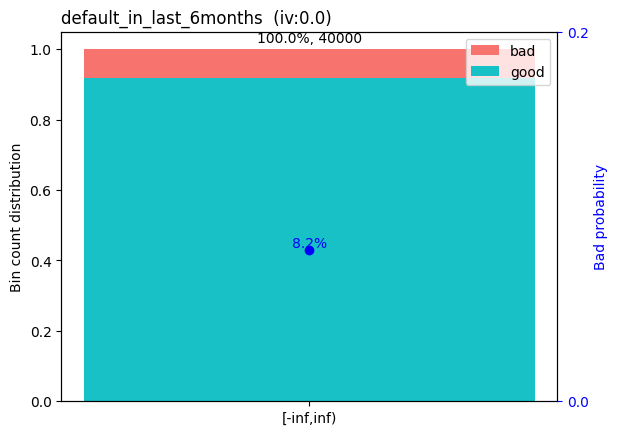

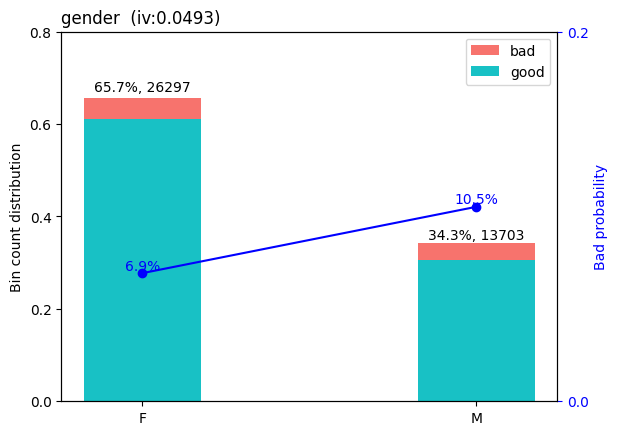

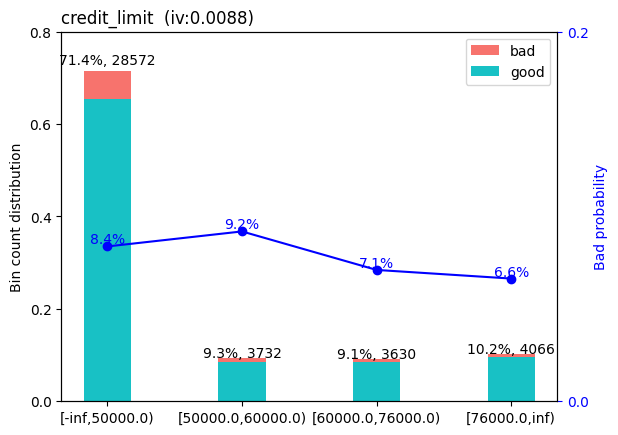

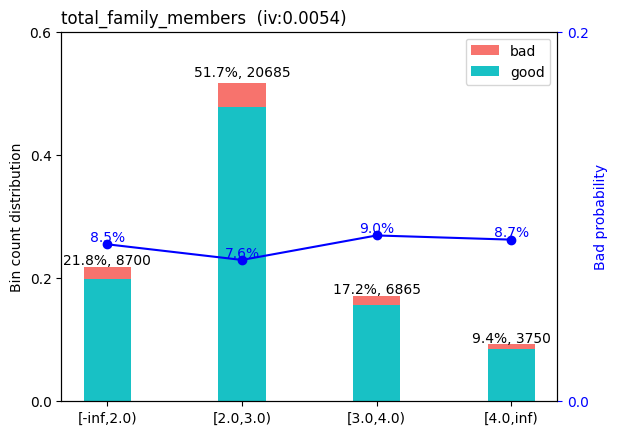

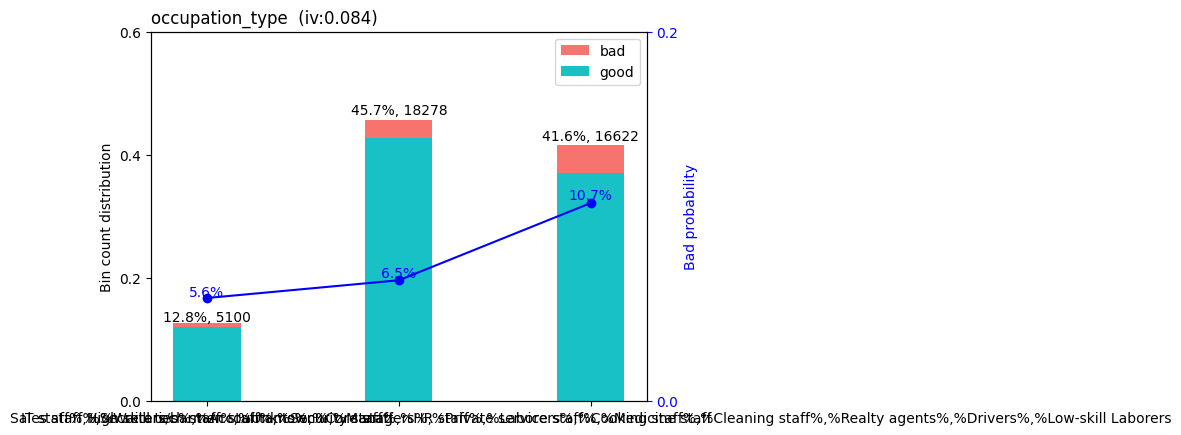

In [122]:
# woe binning ------
bins = sc.woebin(df.drop(columns = ["customer_id", "name"]), y="credit_card_default")
sc.woebin_plot(bins)

In [123]:
# converting train and test into woe values
train_woe = sc.woebin_ply(df, bins)
train_woe.drop(columns = ["customer_id", "name"], inplace = True)
train_woe.head(10)

[INFO] converting into woe values ...


,credit_card_default,credit_limit_used(%)_woe,net_yearly_income_woe,owns_car_woe,credit_score_woe,age_woe,owns_house_woe,no_of_children_woe,migrant_worker_woe,gender_woe,total_family_members_woe,credit_limit_woe,prev_defaults_woe,default_in_last_6months_woe,yearly_debt_payments_woe,no_of_days_employed_woe,occupation_type_woe
0,1,1.196266,0.065289,0.038253,3.219730,0.014596,-0.002649,-0.059590,0.236919,-0.176658,0.043458,0.028516,0.0,0.0,0.120206,0.377366,-0.237678
1,0,-2.454274,0.065289,0.038253,-2.928118,-0.007398,-0.002649,-0.059590,-0.057965,0.280078,-0.070685,0.028516,0.0,0.0,-0.180402,0.087713,0.301509
2,0,-2.454274,0.065289,0.038253,3.219730,0.030427,-0.002649,-0.059590,-0.057965,0.280078,-0.070685,0.028516,0.0,0.0,-0.145680,0.377366,0.301509
3,0,-2.454274,0.065289,0.038253,-2.928118,-0.071899,-0.002649,-0.059590,-0.057965,-0.176658,-0.070685,0.028516,0.0,0.0,0.120206,-0.503049,-0.406532
4,0,1.196266,-0.478451,-0.079915,-2.928118,0.014596,-0.002649,-0.059590,-0.057965,0.280078,0.043458,0.129910,0.0,0.0,0.120206,0.087713,-0.406532
5,0,-2.454274,-0.108541,-0.079915,-2.928118,0.014596,0.006043,-0.059590,0.236919,-0.176658,-0.070685,0.028516,0.0,0.0,0.120206,0.087713,-0.406532
6,0,-2.454274,-0.108541,0.038253,-2.928118,-0.071899,-0.002649,0.155408,-0.057965,0.280078,0.103540,0.028516,0.0,0.0,-0.145680,-0.503049,-0.237678
7,0,1.196266,-0.108541,-0.079915,-2.928118,0.014596,-0.002649,0.155408,-0.057965,-0.176658,0.103540,0.028516,0.0,0.0,0.120206,0.087713,-0.406532
8,0,-2.454274,0.065289,0.038253,-2.928118,0.128561,-0.002649,-0.059590,-0.057965,-0.176658,-0.070685,-0.149832,0.0,0.0,0.120206,-0.503049,0.301509
10,0,-2.454274,-0.142601,0.038253,-2.928118,0.030427,-0.002649,-0.059590,0.236919,-0.176658,-0.070685,0.028516,0.0,0.0,-0.180402,0.087713,-0.237678


In [124]:
# dropping text columns that aren't necessary like 'customer_id' and 'name'
old_df = df.copy()

df.drop(['customer_id', 'name'], axis=1, inplace=True)
df.drop(low_IV_cols, axis=1, inplace=True)
df.head()

,gender,no_of_days_employed,occupation_type,credit_limit_used(%),credit_score,default_in_last_6months,credit_card_default
34126,F,4181.0,Unknown,23,807.0,0,0
44609,F,365250.0,Unknown,60,858.0,0,0
44264,F,365241.0,Unknown,81,667.0,0,1
33556,F,1882.0,Managers,32,690.0,0,0
28050,M,365244.0,Unknown,65,721.0,0,0


## **Optimizing Data Types**

In [125]:
recc_df = report_on_dataframe(df, unit="MB")
# recc_data_test = report_on_dataframe(test, unit = "MB")
df_opt = optimize_dtypes(df, recc_df)
# test_opt = optimize_dtypes(test, recc_data_test)

print('Original dataframe memory: {:.2f} MB'.format(df.memory_usage(deep=True).sum()/1024/1024))
print('Proposed dataframe memory: {:.2f} MB'.format(df_opt.memory_usage(deep=True).sum()/1024/1024))

# print('Original dataframe memory: {:.2f} MB'.format(test_df.memory_usage(deep=True).sum()/1024/1024))
# print('Proposed dataframe memory: {:.2f} MB'.format(test_df_opt.memory_usage(deep=True).sum()/1024/1024))

print('Reduction proportion in training dataset: {:.3f} %'.format(100 * (df.memory_usage(deep=True).sum()/1024/1024) / (df_opt.memory_usage(deep=True).sum()/1024/1024)))
# print('Reduction proportion in testing dataset'.format(100 * (test.memory_usage(deep=True).sum()/1024/1024) / (test_opt.memory_usage(deep=True).sum()/1024/1024)))

Original dataframe memory: 7.59 MB
Proposed dataframe memory: 1.73 MB
Reduction proportion in training dataset: 437.324 %


In [126]:
df_opt

,gender,no_of_days_employed,occupation_type,credit_limit_used(%),credit_score,default_in_last_6months,credit_card_default
34126,F,4181.0,Unknown,23,807.0,0,0
44609,F,365250.0,Unknown,60,858.0,0,0
44264,F,365241.0,Unknown,81,667.0,0,1
33556,F,1882.0,Managers,32,690.0,0,0
28050,M,365244.0,Unknown,65,721.0,0,0
...,...,...,...,...,...,...,...
18350,M,365242.0,Unknown,17,818.0,0,0
30771,M,3400.0,Drivers,49,841.0,0,0
1466,M,270.0,Laborers,97,509.0,0,1
12615,F,365244.0,Unknown,6,924.0,0,0


In [127]:
df_opt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 34126 to 13543
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   gender                   40000 non-null  category
 1   no_of_days_employed      40000 non-null  float32 
 2   occupation_type          40000 non-null  category
 3   credit_limit_used(%)     40000 non-null  int8    
 4   credit_score             40000 non-null  float16 
 5   default_in_last_6months  40000 non-null  int8    
 6   credit_card_default      40000 non-null  int8    
dtypes: category(2), float16(1), float32(1), int8(3)
memory usage: 1.7 MB


## **Encoding Categorical Variables**

In [128]:
df_opt["gender"] = df_opt["gender"].apply(lambda x : 1 if x == "F" else 0)

In [129]:
occupation_type_encoded_df = pd.get_dummies(df_opt["occupation_type"], prefix= "occupation")
df_opt = pd.concat([df_opt, occupation_type_encoded_df], axis=1)
df_opt.drop(columns=["occupation_type"], inplace=True)
df_opt.head()

,gender,no_of_days_employed,credit_limit_used(%),credit_score,default_in_last_6months,credit_card_default,occupation_Accountants,occupation_Cleaning staff,occupation_Cooking staff,occupation_Core staff,occupation_Drivers,occupation_HR staff,occupation_High skill tech staff,occupation_IT staff,occupation_Laborers,occupation_Low-skill Laborers,occupation_Managers,occupation_Medicine staff,occupation_Private service staff,occupation_Realty agents,occupation_Sales staff,occupation_Secretaries,occupation_Security staff,occupation_Unknown,occupation_Waiters/barmen staff
34126,1,4181.0,23,807.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
44609,1,365250.0,60,858.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
44264,1,365241.0,81,667.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
33556,1,1882.0,32,690.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
28050,0,365244.0,65,721.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Split dataset

In [130]:
# split train-test data
X = df_opt.drop(['credit_card_default'], axis=1)
y = df_opt['credit_card_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print("X=",X_train.shape, X_test.shape)
print("y=",y_train.shape, y_test.shape)

X= (28000, 24) (12000, 24)
y= (28000,) (12000,)


In [131]:
X_train.head()

,gender,no_of_days_employed,credit_limit_used(%),credit_score,default_in_last_6months,occupation_Accountants,occupation_Cleaning staff,occupation_Cooking staff,occupation_Core staff,occupation_Drivers,occupation_HR staff,occupation_High skill tech staff,occupation_IT staff,occupation_Laborers,occupation_Low-skill Laborers,occupation_Managers,occupation_Medicine staff,occupation_Private service staff,occupation_Realty agents,occupation_Sales staff,occupation_Secretaries,occupation_Security staff,occupation_Unknown,occupation_Waiters/barmen staff
10874,1,808.0,50,862.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5705,1,3876.0,65,921.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19397,1,1667.0,16,781.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
44067,1,365252.0,1,732.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
33190,0,365248.0,6,768.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [132]:
y_train

10874    0
5705     0
19397    0
44067    0
33190    0
        ..
248      0
5991     1
24894    0
41624    0
23900    0
Name: credit_card_default, Length: 28000, dtype: int8

In [133]:
# WOE data
X_woe = train_woe.drop(['credit_card_default'], axis=1)
y_woe = train_woe['credit_card_default']

X_train_woe, X_test_woe, y_train_woe, y_test_woe = train_test_split(X_woe, y_woe, test_size=0.3, stratify=y_woe, random_state=42)

print("X=",X_train_woe.shape, X_test_woe.shape)
print("y=",y_train_woe.shape, y_test_woe.shape)

X= (28000, 16) (12000, 16)
y= (28000,) (12000,)


In [134]:
X_train_woe.head()

,credit_limit_used(%)_woe,net_yearly_income_woe,owns_car_woe,credit_score_woe,age_woe,owns_house_woe,no_of_children_woe,migrant_worker_woe,gender_woe,total_family_members_woe,credit_limit_woe,prev_defaults_woe,default_in_last_6months_woe,yearly_debt_payments_woe,no_of_days_employed_woe,occupation_type_woe
15225,-2.454274,0.065289,-0.079915,-2.928118,0.014596,-0.002649,0.155408,-0.057965,-0.176658,0.103540,0.028516,0.0,0.0,0.120206,0.377366,-0.237678
13777,1.196266,0.065289,0.038253,-2.928118,0.014596,0.006043,-0.059590,-0.057965,-0.176658,-0.070685,0.028516,0.0,0.0,0.120206,0.087713,-0.406532
36759,-2.454274,0.065289,-0.079915,-2.928118,-0.085736,-0.002649,-0.059590,-0.057965,0.280078,-0.070685,0.028516,0.0,0.0,0.120206,0.377366,0.301509
26501,-2.454274,-0.191565,0.038253,-2.928118,0.072454,-0.002649,0.078279,-0.057965,0.280078,0.075503,-0.222811,0.0,0.0,0.120206,0.087713,-0.406532
18259,1.196266,-0.108541,0.038253,0.296409,0.030427,-0.002649,-0.059590,-0.057965,-0.176658,0.043458,0.028516,0.0,0.0,0.120206,-0.503049,-0.237678


In [135]:
y_woe

0        1
1        0
2        0
3        0
4        0
        ..
45522    0
45523    0
45524    0
45526    0
45527    0
Name: credit_card_default, Length: 40000, dtype: int64

## **Scaling data**

In [136]:
# scaling the features to standardize
scaler = MinMaxScaler()

cols = X_train.columns
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

## **Data Imbalancing Handling**

In [137]:
# initialize SMOTE method
sm = SMOTE(random_state=42)
X_train,y_train = sm.fit_resample(X_train,y_train)

In [138]:
print("Dimension of X_train_sm Shape:", X_train.shape)
print("Dimension of y_train_sm Shape:", y_train.shape)

Dimension of X_train_sm Shape: (51428, 24)
Dimension of y_train_sm Shape: (51428,)


In [139]:
X_train = pd.DataFrame(data=X_train, columns=cols)
print("X_train.shape:",X_train.shape)
y_train = pd.Series(y_train)
print("y_train.shape:",y_train.shape)
X_train.head()

X_train.shape: (51428, 24)
y_train.shape: (51428,)


,gender,no_of_days_employed,credit_limit_used(%),credit_score,default_in_last_6months,occupation_Accountants,occupation_Cleaning staff,occupation_Cooking staff,occupation_Core staff,occupation_Drivers,occupation_HR staff,occupation_High skill tech staff,occupation_IT staff,occupation_Laborers,occupation_Low-skill Laborers,occupation_Managers,occupation_Medicine staff,occupation_Private service staff,occupation_Realty agents,occupation_Sales staff,occupation_Secretaries,occupation_Security staff,occupation_Unknown,occupation_Waiters/barmen staff
0,1.0,0.002207,0.505051,0.806236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.010606,0.656566,0.937639,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.004559,0.161616,0.625835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.000000,0.010101,0.516704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.999989,0.060606,0.596882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [140]:
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: credit_card_default, dtype: float64

# **Logit Regression in Scorecard**

## **Logit Regression for Original Dataset**

In [ ]:
from statsmodels.discrete.discrete_model import Logit
logit = Logit(y_train, X_train)
logit_fit = logit.fit()

         Current function value: 0.098695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
logit_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     credit_card_default   No. Observations:                38552
Model:                           Logit   Df Residuals:                    38528
Method:                            MLE   Df Model:                           23
Date:                 Sun, 19 Mar 2023   Pseudo R-squ.:                  0.8576
Time:                         14:11:39   Log-Likelihood:                -3804.9
converged:                       False   LL-Null:                       -26722.
Covariance Type:             nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
gender                              -0.1955      0.072     -2.731      0.006      -0.336      -0.055
no_of_days_employed                 -0.3089      0.115     -2.676      0.007      -0.535      -0.083
credit_limit_used(%)                 9.2967      0.219     42.504      0.000       8.868       9.725
credit_score                       -26.3302      0.615    -42.825      0.000     -27.535     -25.125
default_in_last_6months            216.5010   1.34e+04      0.016      0.987   -2.61e+04    2.65e+04
occupation_Accountants               3.8706      0.315     12.299      0.000       3.254       4.487
occupation_Cleaning staff            4.3175      0.348     12.407      0.000       3.635       5.000
occupation_Cooking staff             4.5699      0.331     13.791      0.000       3.920       5.219
occupation_Core staff                4.1222      0.286     14.414      0.000       3.562       4.683
occupation_Drivers                   4.1146      0.283     14.552      0.000       3.560       4.669
occupation_HR staff                  1.1312      1.233      0.918      0.359      -1.285       3.547
occupation_High skill tech staff     2.8968      0.318      9.113      0.000       2.274       3.520
occupation_IT staff                 -3.2122      3.654     -0.879      0.379     -10.374       3.949
occupation_Laborers                  3.9506      0.271     14.559      0.000       3.419       4.482
occupation_Low-skill Laborers        3.9416      0.412      9.569      0.000       3.134       4.749
occupation_Managers                  3.5844      0.290     12.379      0.000       3.017       4.152
occupation_Medicine staff            3.4496      0.333     10.346      0.000       2.796       4.103
occupation_Private service staff     2.4504      0.430      5.695      0.000       1.607       3.294
occupation_Realty agents             2.4885      0.792      3.143      0.002       0.937       4.040
occupation_Sales staff               3.9199      0.280     14.009      0.000       3.371       4.468
occupation_Secretaries               2.2090      0.592      3.729      0.000       1.048       3.370
occupation_Security staff            3.0221      0.347      8.710      0.000       2.342       3.702
occupation_Unknown                   3.5768      0.276     12.957      0.000       3.036       4.118
occupation_Waiters/barmen staff      5.1816      0.430     12.037      0.000       4.338       6.025
====================================================================================================

Possibly complete quasi-separation: A fraction 0.61 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## **Logistic Regression for WOE Data**

In [141]:
# logistic regression ------
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train_woe, y_train_woe)
# lr.coef_
# lr.intercept_

# predicted proability
train_pred = lr.predict_proba(X_train_woe)[:,1]
test_pred = lr.predict_proba(X_test_woe)[:,1]

# performance ks & roc ------
train_perf = sc.perf_eva(y_train_woe, train_pred, title = "train")
test_perf = sc.perf_eva(y_test_woe, test_pred, title = "test")

# score ------
card = sc.scorecard(bins, lr, X_train_woe.columns)
# credit score
score = sc.scorecard_ply(old_df, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp = None)
#test_score = sc.scorecard_ply(test_woe, card, print_step=0)

ValueError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
score

,no_of_days_employed_points,credit_limit_used(%)_points,credit_score_points,occupation_type_points,credit_limit_points,owns_car_points,gender_points,yearly_debt_payments_points,age_points,score
0,-26.0,-88.0,-234.0,9.0,-3.0,-7.0,7.0,-9.0,0.0,213.0
1,-7.0,185.0,207.0,-11.0,-1.0,-7.0,-11.0,14.0,2.0,935.0
3,37.0,185.0,207.0,9.0,-1.0,-7.0,7.0,-9.0,14.0,1006.0
4,-7.0,-88.0,207.0,9.0,-8.0,15.0,-11.0,-9.0,0.0,672.0
6,37.0,185.0,207.0,9.0,-1.0,-7.0,-11.0,14.0,14.0,1011.0
...,...,...,...,...,...,...,...,...,...,...
45520,-7.0,-88.0,207.0,-11.0,-1.0,15.0,-11.0,14.0,0.0,682.0
45521,37.0,185.0,207.0,9.0,-1.0,-7.0,7.0,-9.0,0.0,992.0
45524,-26.0,185.0,-21.0,9.0,3.0,-7.0,7.0,-9.0,2.0,707.0
45526,-7.0,-93.0,207.0,-11.0,-1.0,15.0,-11.0,-9.0,-4.0,650.0


(array([ 1460.,   673.,   375.,  1191.,   441.,  5180.,  3433.,   324.,
        12158.,  4765.]),
 array([ 159. ,  251.4,  343.8,  436.2,  528.6,  621. ,  713.4,  805.8,
         898.2,  990.6, 1083. ]),
 <BarContainer object of 10 artists>)

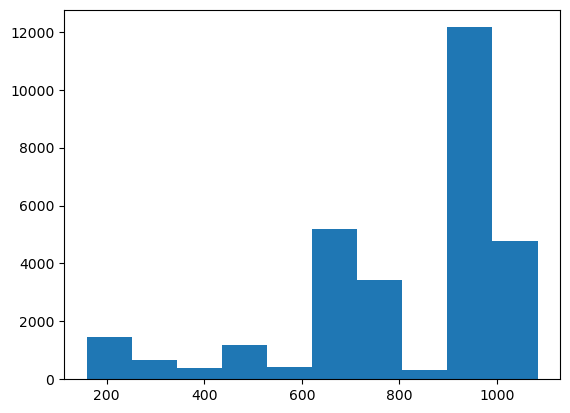

In [ ]:
plt.hist(score["score"])

# **Different Models for Credit Scoring**

In [142]:
# evaluation function
def evaluation(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("="*50)

    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    print("Accuracy of TRAIN data:", 100*accuracy_score(y_train, y_train_pred))
    print("F1_Score of TRAIN data:", 100*f1_score(y_train, y_train_pred, average="macro"))
    print("="*50)

    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    print("Accuracy of TEST data:", 100*accuracy_score(y_test, y_test_pred))
    print("F1_Score of TEST data:", 100*f1_score(y_test, y_test_pred, average="macro"))
    print("="*50)

    # calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("RMSE: ", rmse)

    # calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_test_pred, average=None)
    print("ROC AUC score: ", roc_auc)


## **Logisitc Regression**

In [144]:
# initialize LogisticRegression and fit the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [145]:
# prediction
evaluation(logreg)

[[24378  1336]
 [  903 24811]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     25714
           1       0.95      0.96      0.96     25714

    accuracy                           0.96     51428
   macro avg       0.96      0.96      0.96     51428
weighted avg       0.96      0.96      0.96     51428

Accuracy of TRAIN data: 95.64634051489462
F1_Score of TRAIN data: 95.64603186810201
[[10457   564]
 [   27   952]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     11021
           1       0.63      0.97      0.76       979

    accuracy                           0.95     12000
   macro avg       0.81      0.96      0.87     12000
weighted avg       0.97      0.95      0.96     12000

Accuracy of TEST data: 95.075
F1_Score of TEST data: 86.78221357851719
RMSE:  0.22192341021172146
ROC AUC score:  0.96062290405011


## **Decision Tree**

In [146]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [147]:
# prediction
evaluation(tree_model)

[[25714     0]
 [    1 25713]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25714
           1       1.00      1.00      1.00     25714

    accuracy                           1.00     51428
   macro avg       1.00      1.00      1.00     51428
weighted avg       1.00      1.00      1.00     51428

Accuracy of TRAIN data: 99.99805553395038
F1_Score of TRAIN data: 99.99805553394962
[[10761   260]
 [  125   854]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     11021
           1       0.77      0.87      0.82       979

    accuracy                           0.97     12000
   macro avg       0.88      0.92      0.90     12000
weighted avg       0.97      0.97      0.97     12000

Accuracy of TEST data: 96.79166666666667
F1_Score of TEST data: 89.92396101916387
RMSE:  0.17911821050170565
ROC AUC score:  0.9243636834461909


## **Random Forest**

In [148]:
regr_rfr = RandomForestClassifier(random_state=42, oob_score=True)
regr_rfr.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=42)

In [149]:
# prediction
evaluation(regr_rfr)

[[25713     1]
 [    0 25714]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25714
           1       1.00      1.00      1.00     25714

    accuracy                           1.00     51428
   macro avg       1.00      1.00      1.00     51428
weighted avg       1.00      1.00      1.00     51428

Accuracy of TRAIN data: 99.99805553395038
F1_Score of TRAIN data: 99.99805553394962
[[10680   341]
 [   90   889]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11021
           1       0.72      0.91      0.80       979

    accuracy                           0.96     12000
   macro avg       0.86      0.94      0.89     12000
weighted avg       0.97      0.96      0.97     12000

Accuracy of TEST data: 96.40833333333333
F1_Score of TEST data: 89.25551411606692
RMSE:  0.18951692976266438
ROC AUC score:  0.938564263840626


## **CatBoost**

In [150]:
reg_catb = CatBoostClassifier(random_seed=42)
reg_catb.fit(X_train, y_train)

Learning rate set to 0.055414
0:	learn: 0.5630023	total: 126ms	remaining: 2m 6s
1:	learn: 0.4261302	total: 197ms	remaining: 1m 38s
2:	learn: 0.3280301	total: 233ms	remaining: 1m 17s
3:	learn: 0.2788455	total: 274ms	remaining: 1m 8s
4:	learn: 0.2203404	total: 323ms	remaining: 1m 4s
5:	learn: 0.1844169	total: 366ms	remaining: 1m
6:	learn: 0.1534375	total: 410ms	remaining: 58.2s
7:	learn: 0.1336559	total: 450ms	remaining: 55.8s
8:	learn: 0.1193364	total: 493ms	remaining: 54.3s
9:	learn: 0.1087031	total: 535ms	remaining: 52.9s
10:	learn: 0.1018037	total: 575ms	remaining: 51.7s
11:	learn: 0.0961057	total: 623ms	remaining: 51.3s
12:	learn: 0.0898811	total: 660ms	remaining: 50.1s
13:	learn: 0.0861790	total: 697ms	remaining: 49.1s
14:	learn: 0.0835908	total: 734ms	remaining: 48.2s
15:	learn: 0.0801131	total: 782ms	remaining: 48.1s
16:	learn: 0.0780437	total: 841ms	remaining: 48.6s
17:	learn: 0.0765628	total: 903ms	remaining: 49.3s
18:	learn: 0.0753816	total: 947ms	remaining: 48.9s
19:	learn: 0

In [155]:
# prediction
evaluation(reg_catb)

[[25458   256]
 [   46 25668]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     25714
           1       0.99      1.00      0.99     25714

    accuracy                           0.99     51428
   macro avg       0.99      0.99      0.99     51428
weighted avg       0.99      0.99      0.99     51428

Accuracy of TRAIN data: 99.41277125301391
F1_Score of TRAIN data: 99.41276146140932
[[10767   254]
 [  112   867]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     11021
           1       0.77      0.89      0.83       979

    accuracy                           0.97     12000
   macro avg       0.88      0.93      0.90     12000
weighted avg       0.97      0.97      0.97     12000

Accuracy of TEST data: 96.95
F1_Score of TEST data: 90.45009784735811
RMSE:  0.1746424919657298
ROC AUC score:  0.9312753190375992


## **XGBoost**

In [151]:
xgb_model = XGBClassifier(random_seed=42)
xgb_model.fit(X_train, y_train)

[09:29:09] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [154]:
# prediction
evaluation(xgb_model)

[[25614   100]
 [   98 25616]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25714
           1       1.00      1.00      1.00     25714

    accuracy                           1.00     51428
   macro avg       1.00      1.00      1.00     51428
weighted avg       1.00      1.00      1.00     51428

Accuracy of TRAIN data: 99.6149957221747
F1_Score of TRAIN data: 99.61499572159242
[[10847   174]
 [  155   824]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     11021
           1       0.83      0.84      0.83       979

    accuracy                           0.97     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.97      0.97      0.97     12000

Accuracy of TEST data: 97.25833333333334
F1_Score of TEST data: 90.93236571477867
RMSE:  0.16557978942693055
ROC AUC score:  0.912943568870609


In [ ]:
xgb_model.feature_importances_

array([0.00675631, 0.01199557, 0.1511477 , 0.5563976 , 0.03397043,
       0.01223659, 0.01650092, 0.00971052, 0.01367285, 0.01423911,
       0.        , 0.02390504, 0.        , 0.01152375, 0.00386777,
       0.00626034, 0.01132194, 0.02747406, 0.00206754, 0.0162976 ,
       0.0344857 , 0.01210996, 0.0147626 , 0.00929605], dtype=float32)

In [163]:
from xgboost import plot_importance

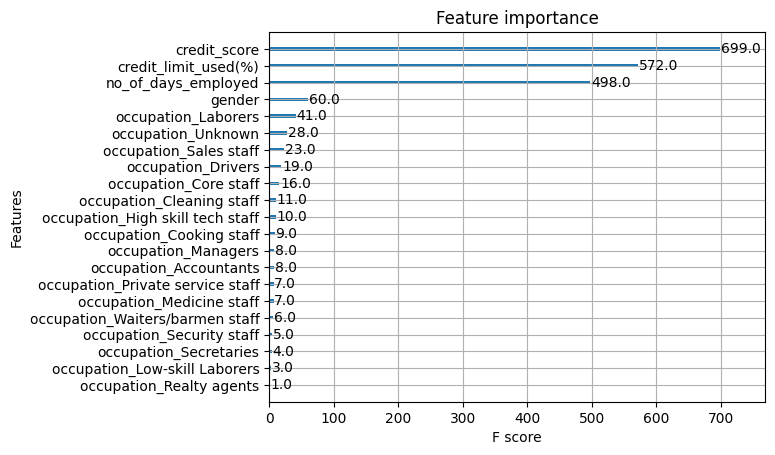

<Figure size 640x480 with 0 Axes>

In [164]:
plot_importance(xgb_model)
plt.show()
plt.savefig("Feature importance.png")

## **LightGBM**

In [152]:
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [153]:
# prediction
evaluation(lgbm_model)

[[25253   461]
 [   74 25640]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     25714
           1       0.98      1.00      0.99     25714

    accuracy                           0.99     51428
   macro avg       0.99      0.99      0.99     51428
weighted avg       0.99      0.99      0.99     51428

Accuracy of TRAIN data: 98.95971066345182
F1_Score of TRAIN data: 98.95965175177291
[[10716   305]
 [   96   883]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11021
           1       0.74      0.90      0.81       979

    accuracy                           0.97     12000
   macro avg       0.87      0.94      0.90     12000
weighted avg       0.97      0.97      0.97     12000

Accuracy of TEST data: 96.65833333333333
F1_Score of TEST data: 89.82924266473758
RMSE:  0.1828022611092835
ROC AUC score:  0.9371331580836622


## **KNN**

In [156]:
# # iterating knn model for all values of k from 1-39
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

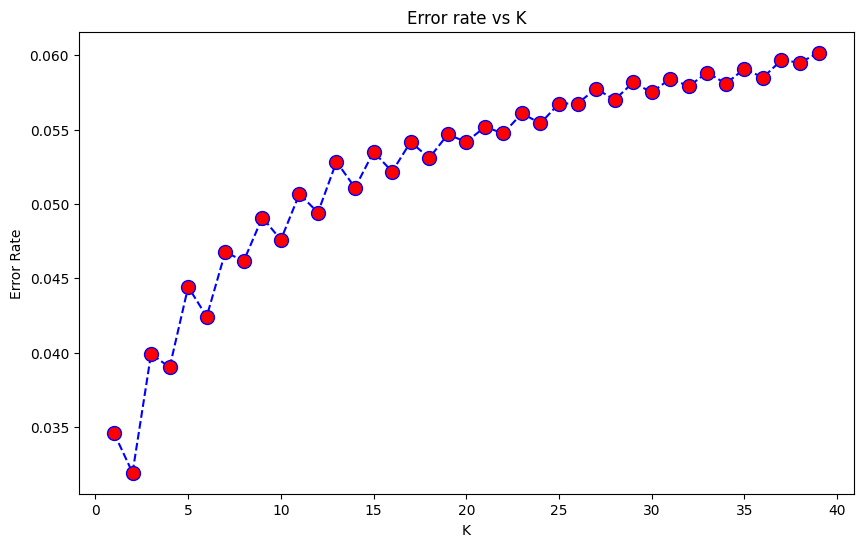

In [157]:
# ploting the error_rate

plt.figure(figsize=[10,6])
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed',
          marker='o', markerfacecolor='red', markersize=10)
plt.title('Error rate vs K')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [160]:
np.argmin(error_rate)

1

**Choose k = 2**

In [161]:
# # building knn and fit the model
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [162]:
# # Evaluation
evaluation(knn)

[[25714     0]
 [  319 25395]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     25714
           1       1.00      0.99      0.99     25714

    accuracy                           0.99     51428
   macro avg       0.99      0.99      0.99     51428
weighted avg       0.99      0.99      0.99     51428

Accuracy of TRAIN data: 99.37971533017034
F1_Score of TRAIN data: 99.37969146360886
[[10757   264]
 [  119   860]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     11021
           1       0.77      0.88      0.82       979

    accuracy                           0.97     12000
   macro avg       0.88      0.93      0.90     12000
weighted avg       0.97      0.97      0.97     12000

Accuracy of TEST data: 96.80833333333332
F1_Score of TEST data: 90.0194119831031
RMSE:  0.1786523626114882
ROC AUC score:  0.9272465630893719
